<a href="https://colab.research.google.com/github/AdityaKRaj/Pytorch/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 1/15, Federated Aggregation Completed
Episode 2/15, Federated Aggregation Completed
Episode 3/15, Federated Aggregation Completed
Episode 4/15, Federated Aggregation Completed
Episode 5/15, Federated Aggregation Completed
Episode 6/15, Federated Aggregation Completed
Episode 7/15, Federated Aggregation Completed
Episode 8/15, Federated Aggregation Completed
Episode 9/15, Federated Aggregation Completed
Episode 10/15, Federated Aggregation Completed
Episode 11/15, Federated Aggregation Completed
Episode 12/15, Federated Aggregation Completed
Episode 13/15, Federated Aggregation Completed
Episode 14/15, Federated Aggregation Completed
Episode 15/15, Federated Aggregation Completed
Success Rate (Random Policy): 0.0%
Success Rate (Trained Policy): 0.0%
Average Steps Taken (Random Policy): 200.0
Average Steps Taken (Trained Policy): 200.0
Average Collisions (Random Policy): 0.84
Average Collisions (Trained Policy): 0.16
Reward per Step (Random Policy): 45.04756789469554
Reward per S

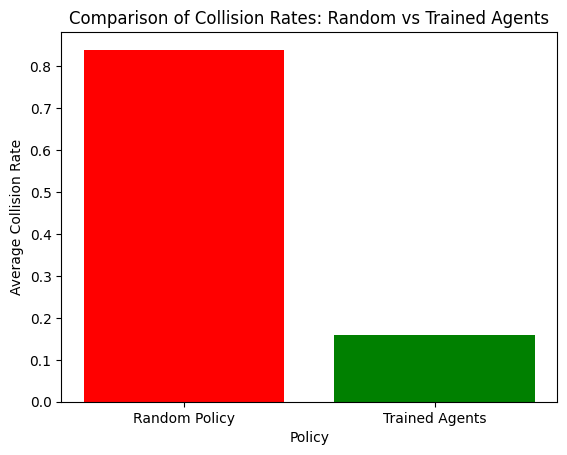

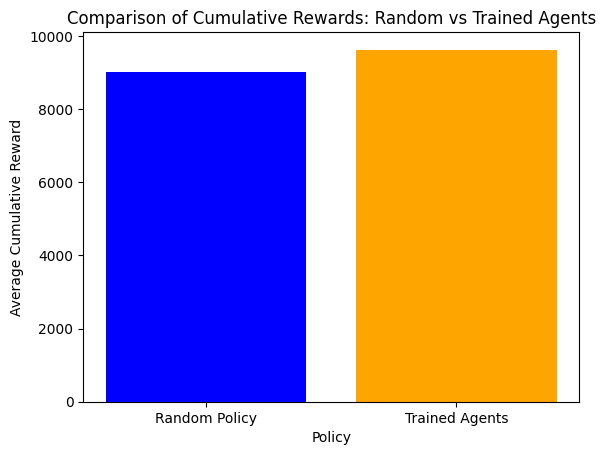

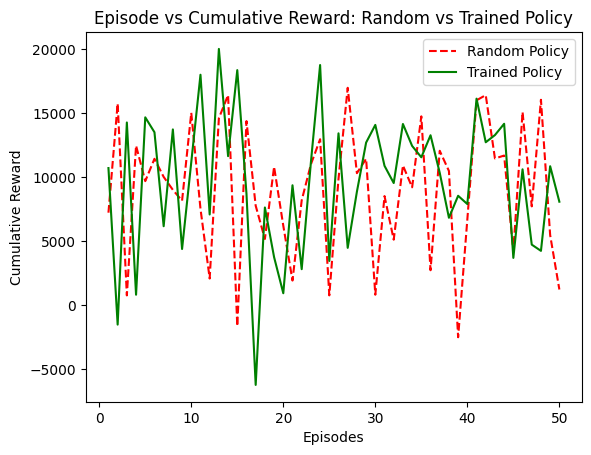

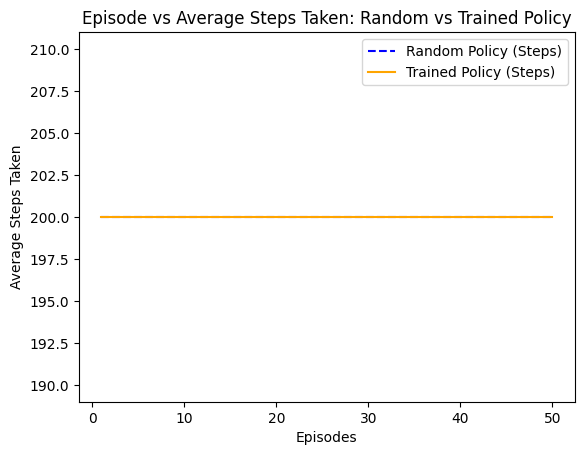

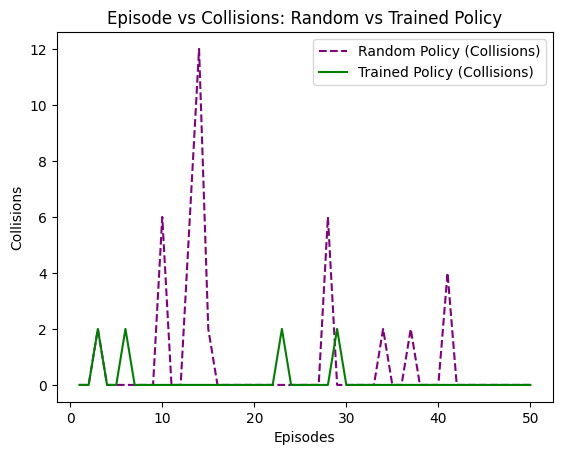

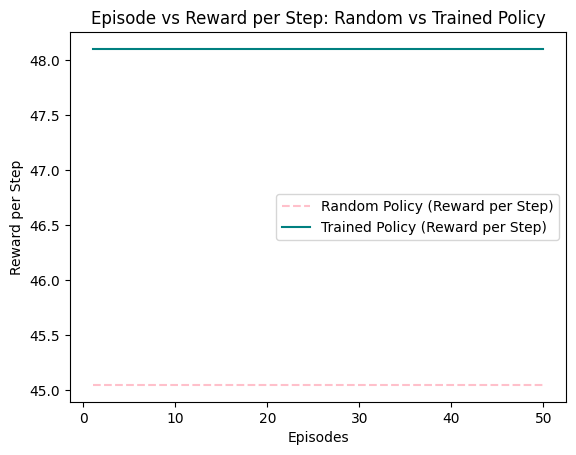

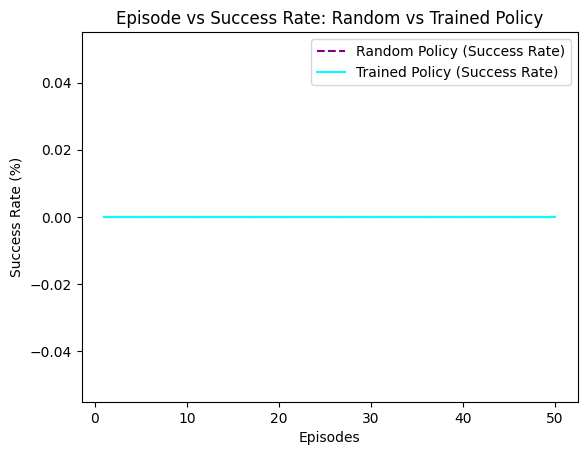

In [18]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Load Data
cab_ids = []
with open('/content/cab_id.txt', 'r') as file:
    for line in file:
        if 'cab id' in line:
            cab_id = line.split('"')[1]
            cab_ids.append(cab_id)

columns = ['latitude', 'longitude', 'occupancy', 'timestamp']
cabspot_data = []

for cab_id in cab_ids:
    cab_file_path = f'/content/new_{cab_id}.txt'
    if os.path.exists(cab_file_path):
        cab_df = pd.read_csv(cab_file_path, delimiter=' ', names=columns)
        cab_df['cab_id'] = cab_id
        cabspot_data.append(cab_df)

if cabspot_data:
    cabspot_df = pd.concat(cabspot_data, ignore_index=True)
else:
    raise ValueError("No cab data loaded. Ensure that the dataset files are correctly uploaded.")

cabspot_df['timestamp'] = pd.to_datetime(cabspot_df['timestamp'], unit='s')
cabspot_df['latitude'] = cabspot_df['latitude'].round(3)
cabspot_df['longitude'] = cabspot_df['longitude'].round(3)


# Optimized Traffic Environment Class
class OptimizedTrafficEnvironment:
    def __init__(self, cabspot_df, grid_size=0.01, collision_radius=.01, max_steps=100):
        self.cabspot_df = cabspot_df
        self.grid_size = grid_size
        self.agents = cabspot_df['cab_id'].unique()
        self.positions = {}
        self.collision_radius = collision_radius
        self.max_steps = max_steps
        self.steps = 0

        # Initialize goal positions (drop-off points) and high-demand areas (pick-up points)
        self.goal_positions = {agent: self._get_random_goal_position() for agent in self.agents}
        self.high_demand_areas = {agent: self._get_random_high_demand_area() for agent in self.agents}

    def reset(self):
        self.steps = 0
        for agent in self.agents:
            random_row = self.cabspot_df[self.cabspot_df['cab_id'] == agent].sample()
            grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
            grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
            self.positions[agent] = (grid_x, grid_y, random_row['occupancy'].values[0])

        # Reset goal and demand areas for each agent
        self.goal_positions = {agent: self._get_random_goal_position() for agent in self.agents}
        self.high_demand_areas = {agent: self._get_random_high_demand_area() for agent in self.agents}

    def _get_random_goal_position(self):
        random_row = self.cabspot_df.sample()  # Randomly select a row from the dataset
        grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
        grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
        return grid_x, grid_y

    def _get_random_high_demand_area(self):
        random_row = self.cabspot_df.sample()  # Randomly select a row from the dataset
        grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
        grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
        return grid_x, grid_y

    def step(self, actions):
        rewards = {}
        next_positions = {}
        steps_without_collision = 0

        for agent, action in actions.items():
            current_pos = self.positions[agent]
            next_pos, penalty = self._take_action(current_pos, action)
            next_positions[agent] = next_pos
            rewards[agent] = penalty  # Reward for taking action, includes penalty for staying idle

        # Check for collisions
        collisions = set()
        for agent, next_pos in next_positions.items():
            collision = False
            for other_agent, other_pos in next_positions.items():
                if agent != other_agent:
                    if self._check_collision(next_pos, other_pos):
                        collision = True
                        collisions.add(agent)
                        collisions.add(other_agent)

            if collision:
                rewards[agent] = -10  # Penalty for collision
            else:
                rewards[agent] += self._get_reward(next_pos, steps_without_collision, self.goal_positions[agent], self.high_demand_areas[agent])

        self.positions = next_positions
        self.steps += 1
        done = self.steps >= self.max_steps
        return self.positions, rewards, done

    def _take_action(self, position, action):
        actions_map = {
            0: (0, self.grid_size),  # North
            1: (0, -self.grid_size),  # South
            2: (self.grid_size, 0),  # East
            3: (-self.grid_size, 0),  # West
            4: (0, 0)  # Stay (penalty for staying idle)
        }

        grid_x, grid_y, occupancy = position
        move = actions_map[action]

        if action == 4:
            return (grid_x, grid_y, occupancy), -5  # Penalty for staying idle

        return (grid_x + move[0], grid_y + move[1], occupancy), 0

    def _check_collision(self, pos1, pos2):
        dist_x = abs(pos1[0] - pos2[0])
        dist_y = abs(pos1[1] - pos2[1])
        return dist_x <= self.collision_radius and dist_y <= self.collision_radius

    def _get_reward(self, position, steps_without_collision, goal_position, high_demand_area):
        dist_to_goal = np.sqrt((position[0] - goal_position[0]) ** 2 + (position[1] - goal_position[1]) ** 2)
        dist_to_demand = np.sqrt((position[0] - high_demand_area[0]) ** 2 + (position[1] - high_demand_area[1]) ** 2)

        if dist_to_goal < 5:
            reward = 20 - dist_to_goal  # Higher reward as agent gets closer
        else:
            reward = 5 - dist_to_goal

        reward -= steps_without_collision * 0.05

        if position[2] == 0 and dist_to_demand < 5:
            reward += 10 - dist_to_demand  # Reward for being near high-demand areas when free

        return reward


# DQN Agent implementation
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model


# Federated Server
class FederatedServer:
    def __init__(self, agents):
        self.agents = agents

    def aggregate_weights(self):
        new_weights = [np.zeros_like(weight) for weight in self.agents[0].model.get_weights()]
        for agent in self.agents:
            agent_weights = agent.model.get_weights()
            for i in range(len(new_weights)):
                new_weights[i] += agent_weights[i]
        for i in range(len(new_weights)):
            new_weights[i] /= len(self.agents)
        return new_weights

    def distribute_weights(self, new_weights):
        for agent in self.agents:
            agent.model.set_weights(new_weights)
           ### #federated training
def federated_train(environment, agents, server, episodes=10):
    max_time_steps = 200
    for e in range(episodes):
        environment.reset()
        states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]
        for time in range(max_time_steps):
            actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}
            next_positions, rewards, done = environment.step(actions)
            states = [np.reshape(next_positions[agent], [1, 3]) for agent in environment.agents]
            if done:
                break

        # Federated weight aggregation
        new_weights = server.aggregate_weights()
        server.distribute_weights(new_weights)
        print(f"Episode {e + 1}/{episodes}, Federated Aggregation Completed")


# Performance Metrics Calculation
def evaluate_agents_with_metrics(environment, agents, policy="trained", episodes=10, max_time_steps=200):
    rewards_per_episode = []
    steps_per_episode = []
    collisions_per_episode = []
    success_count = 0

    for e in range(episodes):
        environment.reset()
        total_reward = 0
        total_steps = 0
        total_collisions = 0

        for time in range(max_time_steps):
            actions = {}

            if policy == "random":
                actions = {agent: random.randint(0, 4) for agent in environment.agents}
            elif policy == "trained":
                states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]
                actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}

            _, rewards, _ = environment.step(actions)
            total_reward += sum(rewards.values())
            total_steps += 1
            total_collisions += sum([1 for reward in rewards.values() if reward == -10])

            if any(reward > 50 for reward in rewards.values()):
                success_count += 1

        rewards_per_episode.append(total_reward)
        steps_per_episode.append(total_steps)
        collisions_per_episode.append(total_collisions)

    success_rate_value = (success_count / episodes) * 100
    avg_steps = np.mean(steps_per_episode)
    avg_collisions = np.mean(collisions_per_episode)

    return rewards_per_episode, steps_per_episode, collisions_per_episode, success_rate_value, avg_steps, avg_collisions


# Evaluation Function for Average Collision and Cumulative Rewards
def evaluate_agents(environment, agents, policy="trained", episodes=10, max_time_steps=200):
    collision_counts = []
    cumulative_rewards = []

    for e in range(episodes):
        environment.reset()
        total_collision_count = 0
        total_cumulative_reward = 0

        for time in range(max_time_steps):
            actions = {}

            if policy == "random":
                actions = {agent: random.randint(0, 4) for agent in environment.agents}
            elif policy == "trained":
                states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]
                actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}

            _, rewards, _ = environment.step(actions)
            total_collision_count += sum(1 for reward in rewards.values() if reward == -10)
            total_cumulative_reward += sum(rewards.values())

        collision_counts.append(total_collision_count)
        cumulative_rewards.append(total_cumulative_reward)

    avg_collision_rate = sum(collision_counts) / len(collision_counts)
    avg_cumulative_reward = sum(cumulative_rewards) / len(cumulative_rewards)

    return avg_collision_rate, avg_cumulative_reward


# --- Training and Evaluation ---

# Create environment, agents, and server
env = OptimizedTrafficEnvironment(cabspot_df)
agents = [DQNAgent(state_size=3, action_size=5) for _ in range(len(env.agents))]
server = FederatedServer(agents)

# Federated training for 15 episodes
federated_train(env, agents, server, episodes=15)

# Evaluate Random Policy
random_rewards, random_steps, random_collisions, random_success_rate, avg_steps_random, avg_collisions_random = evaluate_agents_with_metrics(env, agents, policy="random", episodes=50)

# Evaluate Trained Policy
trained_rewards, trained_steps, trained_collisions, trained_success_rate, avg_steps_trained, avg_collisions_trained = evaluate_agents_with_metrics(env, agents, policy="trained", episodes=50)

# --- Additional Metrics ---

# Success Rate
print(f"Success Rate (Random Policy): {random_success_rate}%")
print(f"Success Rate (Trained Policy): {trained_success_rate}%")

# Average Steps Taken
print(f"Average Steps Taken (Random Policy): {avg_steps_random}")
print(f"Average Steps Taken (Trained Policy): {avg_steps_trained}")

# Collision Rate
print(f"Average Collisions (Random Policy): {avg_collisions_random}")
print(f"Average Collisions (Trained Policy): {avg_collisions_trained}")

# Reward per Step
reward_per_step_random = np.sum(random_rewards) / np.sum(random_steps)
reward_per_step_trained = np.sum(trained_rewards) / np.sum(trained_steps)
print(f"Reward per Step (Random Policy): {reward_per_step_random}")
print(f"Reward per Step (Trained Policy): {reward_per_step_trained}")


# --- Bar Chart Comparisons (Collision Rates & Cumulative Rewards) ---

labels = ['Random Policy', 'Trained Agents']
collision_rates = [avg_collisions_random, avg_collisions_trained]
cumulative_rewards = [np.mean(random_rewards), np.mean(trained_rewards)]

# Plot Collision Rates Comparison (Bar chart)
plt.bar(labels, collision_rates, color=['red', 'green'])
plt.xlabel('Policy')
plt.ylabel('Average Collision Rate')
plt.title('Comparison of Collision Rates: Random vs Trained Agents')
plt.show()

# Plot Cumulative Rewards Comparison (Bar chart)
plt.bar(labels, cumulative_rewards, color=['blue', 'orange'])
plt.xlabel('Policy')
plt.ylabel('Average Cumulative Reward')
plt.title('Comparison of Cumulative Rewards: Random vs Trained Agents')
plt.show()


# --- Line Chart Comparisons (Other Metrics) ---

episodes = list(range(1, 51))

# Plot Cumulative Rewards (Line chart)
plt.plot(episodes, random_rewards, label='Random Policy', color='red', linestyle='--')
plt.plot(episodes, trained_rewards, label='Trained Policy', color='green', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Episode vs Cumulative Reward: Random vs Trained Policy')
plt.legend()
plt.show()

# Plot Average Steps Taken (Line chart)
plt.plot(episodes, random_steps, label='Random Policy (Steps)', color='blue', linestyle='--')
plt.plot(episodes, trained_steps, label='Trained Policy (Steps)', color='orange', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Average Steps Taken')
plt.title('Episode vs Average Steps Taken: Random vs Trained Policy')
plt.legend()
plt.show()

# Plot Collisions (Line chart)
plt.plot(episodes, random_collisions, label='Random Policy (Collisions)', color='purple', linestyle='--')
plt.plot(episodes, trained_collisions, label='Trained Policy (Collisions)', color='green', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Collisions')
plt.title('Episode vs Collisions: Random vs Trained Policy')
plt.legend()
plt.show()

# Plot Reward per Step (Line chart)
reward_per_step = [reward_per_step_random] * len(episodes)
reward_per_step_trained_list = [reward_per_step_trained] * len(episodes)
plt.plot(episodes, reward_per_step, label='Random Policy (Reward per Step)', color='pink', linestyle='--')
plt.plot(episodes, reward_per_step_trained_list, label='Trained Policy (Reward per Step)', color='teal', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Reward per Step')
plt.title('Episode vs Reward per Step: Random vs Trained Policy')
plt.legend()
plt.show()

# Plot Success Rate (Line chart)
success_rates = [random_success_rate] * len(episodes)
success_rates_trained = [trained_success_rate] * len(episodes)
plt.plot(episodes, success_rates, label='Random Policy (Success Rate)', color='purple', linestyle='--')
plt.plot(episodes, success_rates_trained, label='Trained Policy (Success Rate)', color='cyan', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Success Rate (%)')
plt.title('Episode vs Success Rate: Random vs Trained Policy')
plt.legend()
plt.show()

Episode 1/15, Federated Aggregation Completed
Episode 2/15, Federated Aggregation Completed
Episode 3/15, Federated Aggregation Completed
Episode 4/15, Federated Aggregation Completed
Episode 5/15, Federated Aggregation Completed
Episode 6/15, Federated Aggregation Completed
Episode 7/15, Federated Aggregation Completed
Episode 8/15, Federated Aggregation Completed
Episode 9/15, Federated Aggregation Completed
Episode 10/15, Federated Aggregation Completed
Episode 11/15, Federated Aggregation Completed
Episode 12/15, Federated Aggregation Completed
Episode 13/15, Federated Aggregation Completed
Episode 14/15, Federated Aggregation Completed
Episode 15/15, Federated Aggregation Completed


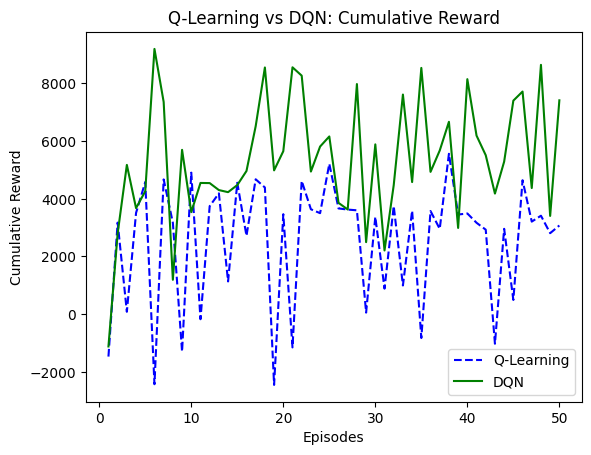

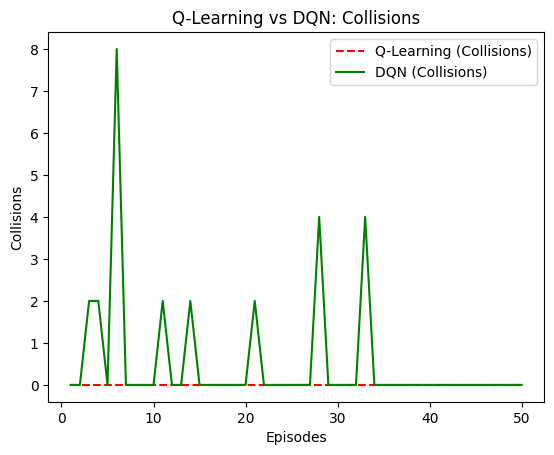

In [26]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os




# Load Data
cab_ids = []
with open('/content/cab_id.txt', 'r') as file:
    for line in file:
        if 'cab id' in line:
            cab_id = line.split('"')[1]
            cab_ids.append(cab_id)


columns = ['latitude', 'longitude', 'occupancy', 'timestamp']
cabspot_data = []


for cab_id in cab_ids:
    cab_file_path = f'/content/new_{cab_id}.txt'
    if os.path.exists(cab_file_path):
        cab_df = pd.read_csv(cab_file_path, delimiter=' ', names=columns)
        cab_df['cab_id'] = cab_id
        cabspot_data.append(cab_df)


if cabspot_data:
    cabspot_df = pd.concat(cabspot_data, ignore_index=True)
else:
    raise ValueError("No cab data loaded. Ensure that the dataset files are correctly uploaded.")


cabspot_df['timestamp'] = pd.to_datetime(cabspot_df['timestamp'], unit='s')
cabspot_df['latitude'] = cabspot_df['latitude'].round(3)
cabspot_df['longitude'] = cabspot_df['longitude'].round(3)




# Optimized Traffic Environment Class
class OptimizedTrafficEnvironment:
    def __init__(self, cabspot_df, grid_size=0.01, collision_radius=.01, max_steps=100):
        self.cabspot_df = cabspot_df
        self.grid_size = grid_size
        self.agents = cabspot_df['cab_id'].unique()
        self.positions = {}
        self.collision_radius = collision_radius
        self.max_steps = max_steps
        self.steps = 0


        # Initialize goal positions (drop-off points) and high-demand areas (pick-up points)
        self.goal_positions = {agent: self._get_random_goal_position() for agent in self.agents}
        self.high_demand_areas = {agent: self._get_random_high_demand_area() for agent in self.agents}


    def reset(self):
        self.steps = 0
        for agent in self.agents:
            random_row = self.cabspot_df[self.cabspot_df['cab_id'] == agent].sample()
            grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
            grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
            self.positions[agent] = (grid_x, grid_y, random_row['occupancy'].values[0])


        # Reset goal and demand areas for each agent
        self.goal_positions = {agent: self._get_random_goal_position() for agent in self.agents}
        self.high_demand_areas = {agent: self._get_random_high_demand_area() for agent in self.agents}


    def _get_random_goal_position(self):
        random_row = self.cabspot_df.sample()  # Randomly select a row from the dataset
        grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
        grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
        return grid_x, grid_y


    def _get_random_high_demand_area(self):
        random_row = self.cabspot_df.sample()  # Randomly select a row from the dataset
        grid_x = (random_row['latitude'].values[0] // self.grid_size).astype(int)
        grid_y = (random_row['longitude'].values[0] // self.grid_size).astype(int)
        return grid_x, grid_y


    def step(self, actions):
        rewards = {}
        next_positions = {}
        steps_without_collision = 0


        # Move agents and calculate penalties for staying idle
        for agent, action in actions.items():
            current_pos = self.positions[agent]
            next_pos, penalty = self._take_action(current_pos, action)
            next_positions[agent] = next_pos
            rewards[agent] = penalty  # Reward for taking action, includes penalty for staying


        # Check for collisions
        collisions = set()
        for agent, next_pos in next_positions.items():
            collision = False
            for other_agent, other_pos in next_positions.items():
                if agent != other_agent:
                    if self._check_collision(next_pos, other_pos):
                        collision = True
                        collisions.add(agent)
                        collisions.add(other_agent)


            if collision:
                rewards[agent] = -10  # Penalty for collision
            else:
                rewards[agent] += self._get_reward(next_pos, steps_without_collision, self.goal_positions[agent], self.high_demand_areas[agent])


        self.positions = next_positions
        self.steps += 1


        done = self.steps >= self.max_steps
        return self.positions, rewards, done


    def _take_action(self, position, action):
        actions_map = {
            0: (0, self.grid_size),  # North
            1: (0, -self.grid_size),  # South
            2: (self.grid_size, 0),  # East
            3: (-self.grid_size, 0),  # West
            4: (0, 0)  # Stay (penalty for staying idle)
        }


        grid_x, grid_y, occupancy = position
        move = actions_map[action]


        if action == 4:
            return (grid_x, grid_y, occupancy), -5  # Penalty for staying idle


        return (grid_x + move[0], grid_y + move[1], occupancy), 0


    def _check_collision(self, pos1, pos2):
        dist_x = abs(pos1[0] - pos2[0])
        dist_y = abs(pos1[1] - pos2[1])
        return dist_x <= self.collision_radius and dist_y <= self.collision_radius


    def _get_reward(self, position, steps_without_collision, goal_position, high_demand_area):
        # Distance to goal and demand area
        dist_to_goal = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)
        dist_to_demand = np.sqrt((position[0] - high_demand_area[0])**2 + (position[1] - high_demand_area[1])**2)


        # Reward for moving toward the goal (closer to drop-off point)
        if dist_to_goal < 5:
            reward = 20 - dist_to_goal  # Higher reward as agent gets closer
        else:
            reward = 5 - dist_to_goal


        # Reward decay based on steps taken
        reward -= steps_without_collision * 0.05


        # Reward for being near high-demand areas (if free)
        if position[2] == 0 and dist_to_demand < 5:
            reward += 10 - dist_to_demand  # Reward for being near high-demand areas when free


        return reward




# DQN Agent implementation
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05  # Allow more exploration
        self.epsilon_decay = 0.995  # Slow down the decay for more exploration
        self.learning_rate = 0.001
        self.model = self._build_model()


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])


    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
   ###     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')

        return model




# Federated Server for DQN Agents
class FederatedServer:
    def __init__(self, agents):
        self.agents = agents


    def aggregate_weights(self):
        new_weights = [np.zeros_like(weight) for weight in self.agents[0].model.get_weights()]
        for agent in self.agents:
            agent_weights = agent.model.get_weights()
            for i in range(len(new_weights)):
                new_weights[i] += agent_weights[i]
        for i in range(len(new_weights)):
            new_weights[i] /= len(self.agents)
        return new_weights


    def distribute_weights(self, new_weights):
        for agent in self.agents:
            agent.model.set_weights(new_weights)




# Federated Training Function for DQN Agents
def federated_train(environment, agents, server, episodes=10):
    max_time_steps = 200
    for e in range(episodes):
        environment.reset()
        states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]


        for time in range(max_time_steps):
            actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}
            next_positions, rewards, done = environment.step(actions)
            states = [np.reshape(next_positions[agent], [1, 3]) for agent in environment.agents]


            if done:
                break


        new_weights = server.aggregate_weights()
        server.distribute_weights(new_weights)
        print(f"Episode {e + 1}/{episodes}, Federated Aggregation Completed")




# Q-Learning Agent Implementation
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min


    def get_state_action_key(self, state):
        return str(state)


    def act(self, state):
        state_key = self.get_state_action_key(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state_key])


    def update(self, state, action, reward, next_state):
        state_key = self.get_state_action_key(state)
        next_state_key = self.get_state_action_key(next_state)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_size)


        q_value = self.q_table[state_key][action]
        next_max = np.max(self.q_table[next_state_key])
        new_q_value = q_value + self.learning_rate * (reward + self.discount_factor * next_max - q_value)


        self.q_table[state_key][action] = new_q_value


        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




# Q-Learning Training
def train_q_learning(env, episodes=50, max_steps=200):
    q_agent = QLearningAgent(state_size=3, action_size=5)
    rewards_per_episode = []


    for e in range(episodes):
        env.reset()
        state = np.reshape(env.positions[env.agents[0]], [1, 3])
        total_reward = 0


        for t in range(max_steps):
            action = q_agent.act(state)
            next_positions, rewards, done = env.step({env.agents[0]: action})
            next_state = np.reshape(next_positions[env.agents[0]], [1, 3])


            reward = rewards[env.agents[0]]
            total_reward += reward
            q_agent.update(state, action, reward, next_state)


            state = next_state


            if done:
                break


        rewards_per_episode.append(total_reward)


    return rewards_per_episode




# Comparison of DQN and Q-Learning
# Evaluation function for DQN agents (assuming it's similar to Q-Learning evaluation)
def evaluate_agents_with_metrics(environment, agents, policy="trained", episodes=10, max_time_steps=200):
    rewards_per_episode = []
    steps_per_episode = []
    collisions_per_episode = []

    for e in range(episodes):
        environment.reset()
        total_reward = 0
        total_steps = 0
        total_collisions = 0

        for time in range(max_time_steps):
            actions = {}

            if policy == "random":
                actions = {agent: random.randint(0, 4) for agent in environment.agents}
            elif policy == "trained":
                states = [np.reshape(environment.positions[agent], [1, 3]) for agent in environment.agents]
                actions = {agent: agents[i].act(states[i]) for i, agent in enumerate(environment.agents)}

            next_positions, rewards, done = environment.step(actions)

            total_reward += sum(rewards.values())
            total_steps += 1
            total_collisions += sum([1 for reward in rewards.values() if reward == -10])

            if done:
                break

        rewards_per_episode.append(total_reward)
        steps_per_episode.append(total_steps)
        collisions_per_episode.append(total_collisions)

    return rewards_per_episode, steps_per_episode, collisions_per_episode





# Initialize Environment and Agents
env = OptimizedTrafficEnvironment(cabspot_df)
agents = [DQNAgent(state_size=3, action_size=5) for _ in range(len(env.agents))]
server = FederatedServer(agents)


# Federated Training of DQN Agents
federated_train(env, agents, server, episodes=15)


# Train Q-Learning
q_learning_rewards = train_q_learning(env, episodes=50)


# Evaluate Q-Learning
q_learning_rewards, q_learning_steps, q_learning_collisions = evaluate_agents_with_metrics_qlearning(env, QLearningAgent(state_size=3, action_size=5), episodes=50)


# Evaluate DQN
dqn_rewards, dqn_steps, dqn_collisions = evaluate_agents_with_metrics(env, agents, policy="trained", episodes=50)


# Plot Comparisons: DQN vs Q-Learning
episodes = range(1, 51)


# Cumulative Reward Comparison
plt.plot(episodes, q_learning_rewards, label='Q-Learning', color='blue', linestyle='--')
plt.plot(episodes, dqn_rewards, label='DQN', color='green', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning vs DQN: Cumulative Reward')
plt.legend()
plt.show()


# Collision Comparison
plt.plot(episodes, q_learning_collisions, label='Q-Learning (Collisions)', color='red', linestyle='--')
plt.plot(episodes, dqn_collisions, label='DQN (Collisions)', color='green', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Collisions')
plt.title('Q-Learning vs DQN: Collisions')
plt.legend()
plt.show()










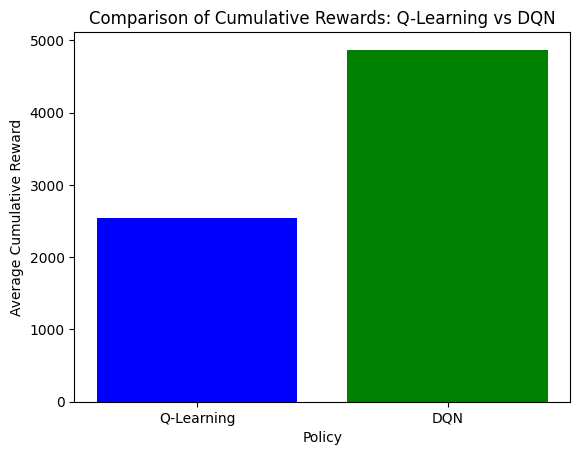

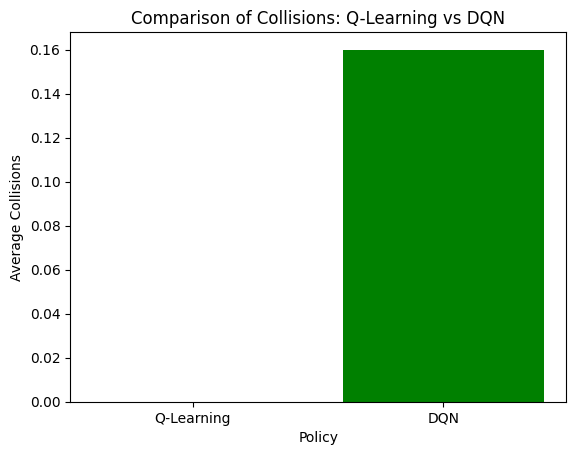

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Comparison using Bar Chart for Cumulative Rewards and Collisions
labels = ['Q-Learning', 'DQN']
episodes = list(range(1, 51))

# Compute the averages for both Q-Learning and DQN over all episodes
avg_q_learning_reward = np.mean(q_learning_rewards)
avg_dqn_reward = np.mean(dqn_rewards)

avg_q_learning_collisions = np.mean(q_learning_collisions)
avg_dqn_collisions = np.mean(dqn_collisions)

# Bar Chart for Cumulative Rewards
cumulative_rewards = [avg_q_learning_reward, avg_dqn_reward]
plt.bar(labels, cumulative_rewards, color=['blue', 'green'])
plt.xlabel('Policy')
plt.ylabel('Average Cumulative Reward')
plt.title('Comparison of Cumulative Rewards: Q-Learning vs DQN')
plt.show()

# Bar Chart for Collisions
collisions = [avg_q_learning_collisions, avg_dqn_collisions]
plt.bar(labels, collisions, color=['red', 'green'])
plt.xlabel('Policy')
plt.ylabel('Average Collisions')
plt.title('Comparison of Collisions: Q-Learning vs DQN')
plt.show()
